# 分析を進めていくとわかってきたこと
前節のデータは、３ヶ月間の総授業回数（`M`）と出席回数（`Y`）だった。  
解析を進めると、さらに新事実が伺えてきた
- 授業日の天気が出席確率に影響

本説では、集計前のデータを使って回帰を行う。集計前データは2396回の出欠を記録している。
- `Weather`：天気（A:はれ B:曇り C:雨)
- `Y`：授業への出席状態の二値（１：出席、０；欠席）  
その他、5.2と同じ。同じ学生（`PersonID`）でも、複数の授業に登録し、出席するため`PersonID`の重複はいくらでもあることに注意。

# 解析の目的
- ３つの説明変数（A, Score, Weather）でYをどれほど予測できるか？
- 説明変数はどれほど出席確率に影響しているか？→ ロジスティック回帰を実施


In [1]:
### インポート

# 数値・確率計算
import pandas as pd
import numpy as np
import scipy.stats as stats

# PyMC
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# 描画
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib
import seaborn as sns
import arviz as az
# plt.rcParams['font.family'] = 'Meiryo'

import sklearn
from sklearn.metrics import roc_curve, roc_auc_score

# ワーニング表示の抑制
import warnings
warnings.simplefilter('ignore')

print(f"{pm.__version__=}")
print(f"{sklearn.__version__=}")

pm.__version__='5.16.2'
sklearn.__version__='1.5.1'


In [2]:
### データの読み込み ◆データファイル5.3 data-attendance-3.txtの構成
# PersonID:学生ID、A:バイト好き区分(1:好き), Weather:天気（A:晴れ、B:曇り、C:雨）
# Y:出欠区分：授業に出席したかどうか（0:欠席、1:出席）

data = pd.read_csv('./input/data-attendance-3.txt')
print('data.shape: ', data.shape)
display(data.head())

data.shape:  (2396, 5)


,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [3]:
data.pivot_table(index="Weather", columns="Y", values="PersonID", 
                 aggfunc="count")

Y,0,1
Weather,,
A,306,953
B,230,500
C,138,269


In [4]:
### 天気の重み係数を設定 ◆テキスト71ページに記述の変換処理
Weather_dict2 = {'A': 0, 'B': 0.2, 'C': 1}
data['Weather_w'] = data['Weather'].map(Weather_dict2)
data.head()

,PersonID,A,Score,Weather,Y,Weather_w
0,1,0,69,B,1,0.2
1,1,0,69,A,1,0.0
2,1,0,69,C,1,1.0
3,1,0,69,A,1,0.0
4,1,0,69,B,1,0.2


↑天気が晴れ（A）の時は、出席率が高そう。  
A, B, C = 0, 0.2, 1　とする(<u>曇りの影響：雨の影響＝１：５とする措置</u>)

**このように背景知識を家庭としてモデリングすることが大切**

# モデリング
- 出席確率 $q = invlogit(b_1 + b_2A + b_3Score + b_4Weather)$
- $Y \sim Bernoulli(q)$
- 学生ごとではなく、出欠ごと、になっている

In [5]:
with pm.Model() as model:
    model.add_coord("data", values=data.index, mutable=True)
    model.add_coord("beta", values=[1, 2, 3, 4], mutable=True)

    Y = pm.ConstantData("Y", value=data["Y"].values, dims="data")
    A = pm.ConstantData("A", value=data["A"].values, dims="data")
    Score = pm.ConstantData("Score", value=data["Score"].values / 200, dims="data")
    W = pm.ConstantData("W", value=data["Weather_w"].values, dims="data")

    b = pm.Uniform("b", lower=-10, upper=10, dims="beta")

    q = pm.Deterministic("q", pm.invlogit(b[0] + b[1]*A + b[2]*Score + b[3]*W), dims="data")

    obs = pm.Bernoulli("obs", p=q, observed=Y, dims="data")

### モデルの表示
model

  b ~ Uniform(-10, 10)
  q ~ Deterministic(f(b))
obs ~ Bernoulli(q)

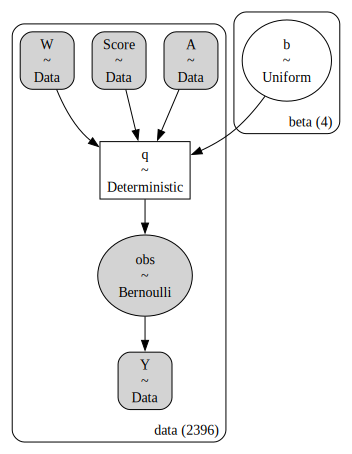

In [6]:
g = pm.model_to_graphviz(model)
display(g)

In [7]:
### 事後分布からのサンプリング 25秒 ◆run-model5-5.R
with model:
    idata = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.8,
                      nuts_sampler='numpyro', random_seed=1234)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 0:  10%|█         | 200/2000 [00:01<00:02, 787.92it/s]





Running chain 0:  20%|██        | 400/2000 [00:01<00:02, 746.47it/s]


Running chain 0:  25%|██▌       | 500/2000 [00:01<00:01, 758.66it/s]


Running chain 0:  30%|███       | 600/2000 [00:01<00:01, 803.37it/s]





Running chain 0:  40%|████      | 800/2000 [00:02<00:01, 914.78it/s]


Running chain 0:  50%|█████     | 1000/2000 [00:02<00:01, 839.03it/s]


Running chain 0:  55%|█████▌    | 1100/2000 [00:02<00:01, 804.92it/s]




Running chain 0:  60%|██████    | 1200/2000 [00:02<00:01, 775.84it/s]



Running chain 0:  65%|██████▌   | 1300/2000 [00:02<00:01, 679.55it/s]


Running chain 0:  70%|███████   | 1400/2000 [00:03<00:00, 697.67it/s]


Running chain 0:  75%|███████▌  | 1500/2000 [00:03<00:00, 702.95it/s]




Running chain 0:  80%|████████  | 1600/2000 [00:03<00:00, 730.25it/s]


Running chain 0:  85%|████████▌ | 1700/2000 [00:03<00:00, 748.31it/

In [8]:
### r_hat>1.1の確認
# 設定
idata_in = idata         # idata名
threshold = 1.01         # しきい値

# しきい値を超えるR_hatの個数を表示
print((az.rhat(idata_in) > threshold).sum())


<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    b        int64 8B 0
    q        int64 8B 0


In [9]:
### 推論データの要約統計情報の表示
var_names = ['b', 'q']
pm.summary(idata, hdi_prob=0.95, var_names=var_names, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[1],0.166,0.230,-0.271,0.615,0.005,0.004,1876.713,1915.642,1.000
b[2],-0.622,0.094,-0.800,-0.429,0.002,0.001,2600.992,2253.657,1.002
b[3],1.969,0.368,1.257,2.702,0.008,0.006,1905.525,1838.483,1.001
b[4],-0.465,0.124,-0.690,-0.207,0.002,0.002,2743.580,2111.229,1.000
q[0],0.679,0.025,0.630,0.727,0.001,0.000,2033.397,2182.617,1.000
...,...,...,...,...,...,...,...,...,...
q[2391],0.605,0.018,0.570,0.641,0.000,0.000,2724.237,2802.818,1.001
q[2392],0.627,0.019,0.590,0.664,0.000,0.000,2718.240,2980.516,1.001
q[2393],0.627,0.019,0.590,0.664,0.000,0.000,2718.240,2980.516,1.001
q[2394],0.513,0.030,0.453,0.571,0.001,0.000,2740.568,2237.245,1.001


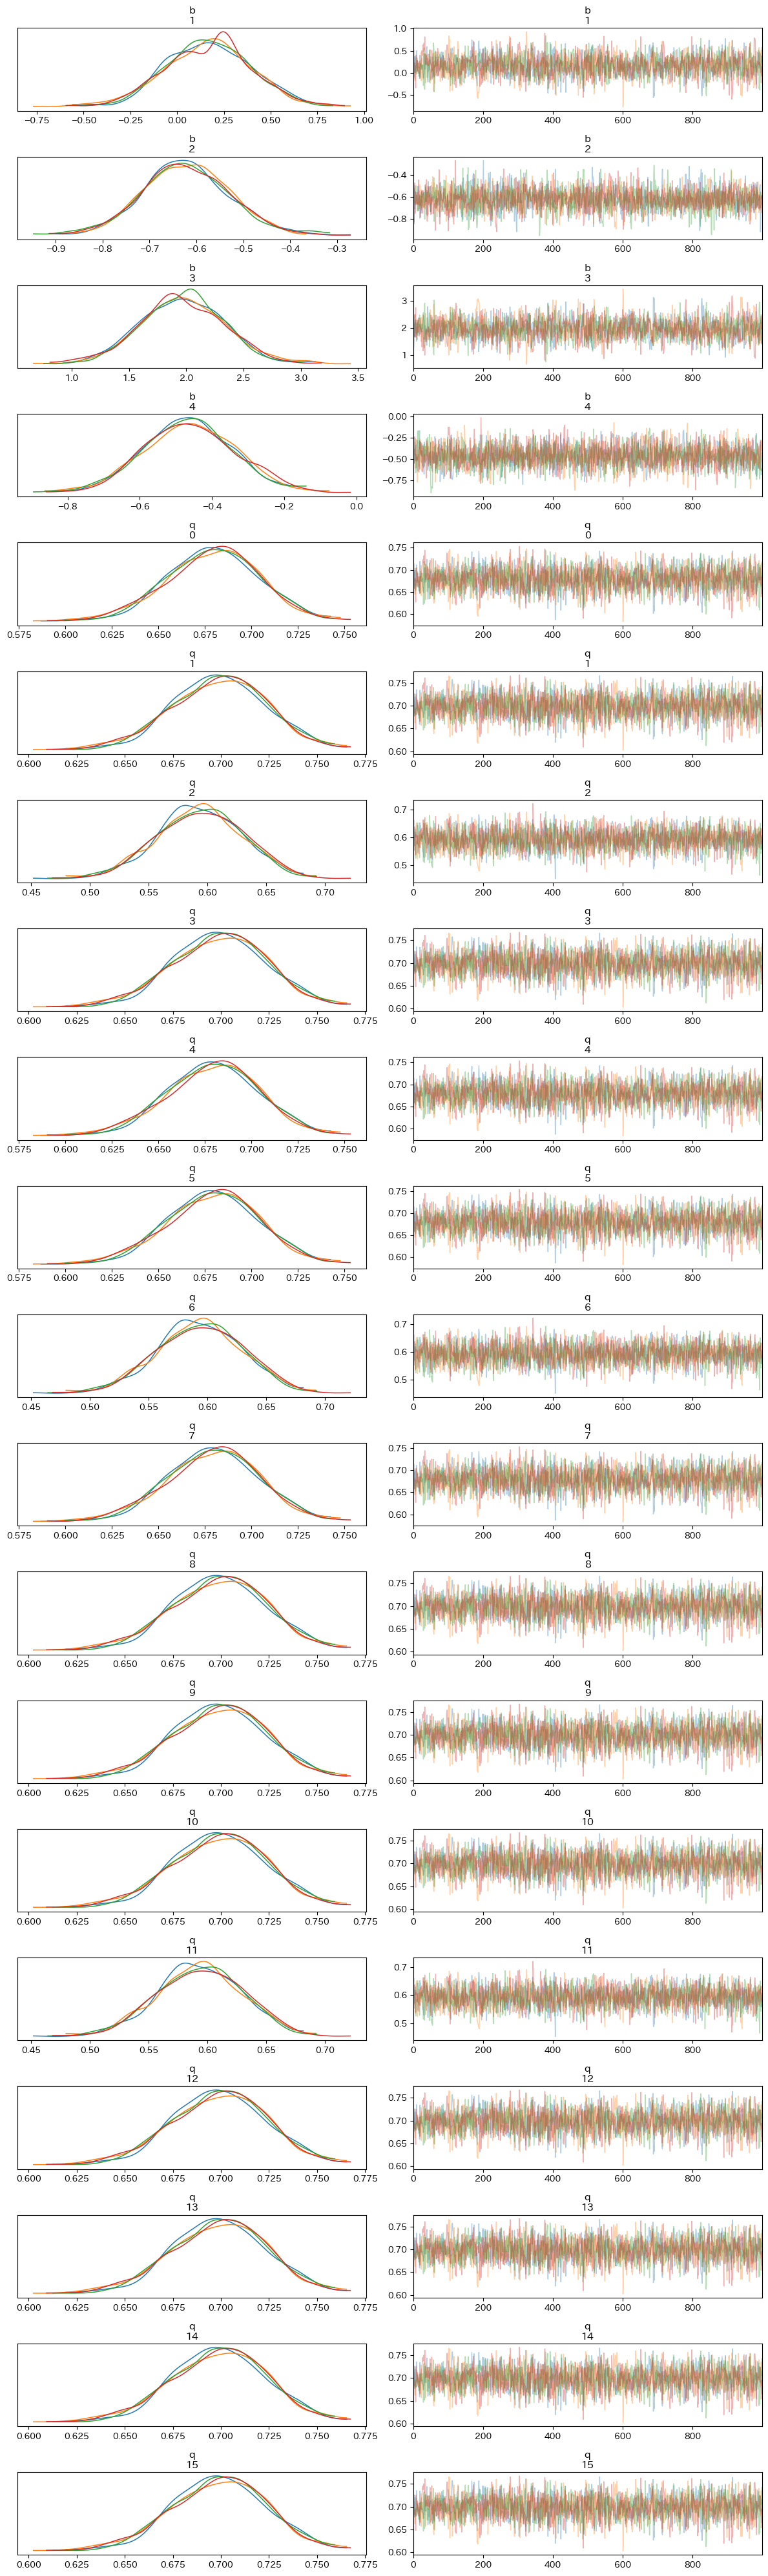

In [10]:
### トレースプロットの表示
pm.plot_trace(idata, compact=False, var_names=var_names)
plt.tight_layout();

In [11]:
### Yの事後予測分布のサンプリング
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=1234))

Sampling: [obs]


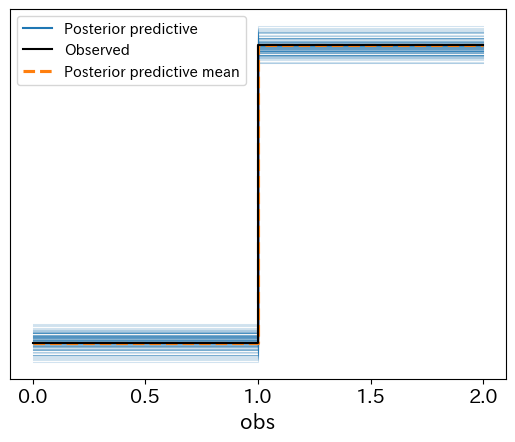

In [12]:
### ppcプロットの描画
pm.plot_ppc(idata, num_pp_samples=100);

In [13]:
### パラメータの要約を確認

## 統計量算出関数：mean,sd,2.5%,25%,50%,75%,97.5%点をデータフレーム化する
def make_stats_df(y):
    probs = [2.5, 25, 50, 75, 97.5]
    columns = ['mean', 'sd'] + [str(s) + '%' for s in probs]
    quantiles = pd.DataFrame(np.percentile(y, probs, axis=0).T, index=y.columns)
    tmp_df = pd.concat([y.mean(axis=0), y.std(axis=0), quantiles], axis=1)
    tmp_df.columns=columns
    return tmp_df

## 要約統計量の算出・表示
# 事後分布サンプリングデータidataからパラメータbを取り出してデータフレーム化
param_samples = pd.DataFrame(
    idata.posterior.b.stack(sample=('chain', 'draw')).T.data,
    columns=['b1', 'b2', 'b3', 'b4'])
# 上記データフレームを統計量算出関数に与えて事後統計量データフレームを作成
params_stats_df = make_stats_df(param_samples)
# 事後統計量データフレームの表示
display(params_stats_df.round(2))

,mean,sd,2.5%,25%,50%,75%,97.5%
b1,0.17,0.23,-0.28,0.01,0.17,0.32,0.61
b2,-0.62,0.09,-0.81,-0.68,-0.62,-0.56,-0.43
b3,1.97,0.37,1.25,1.73,1.96,2.21,2.70
b4,-0.46,0.12,-0.71,-0.55,-0.47,-0.38,-0.22


説明変数$Score$に応じた目的変数$Y$の実測値と確率パラメータ$q$の事後分布を描画する。

(171, 4000)
[[0.57021026 0.65493982 0.58698172 ... 0.53747504 0.58243863 0.60694871]
 [0.5730363  0.65652953 0.58956394 ... 0.54056458 0.58482207 0.60930639]
 [0.57585758 0.65811574 0.59214123 ... 0.543651   0.58720155 0.61165897]
 ...
 [0.90217257 0.86103128 0.89497369 ... 0.90370424 0.87874154 0.89057201]
 [0.90318643 0.86187176 0.89597159 ... 0.90478086 0.87978277 0.89153244]
 [0.9041909  0.86270797 0.8969611  ... 0.90584669 0.88081628 0.89248546]]


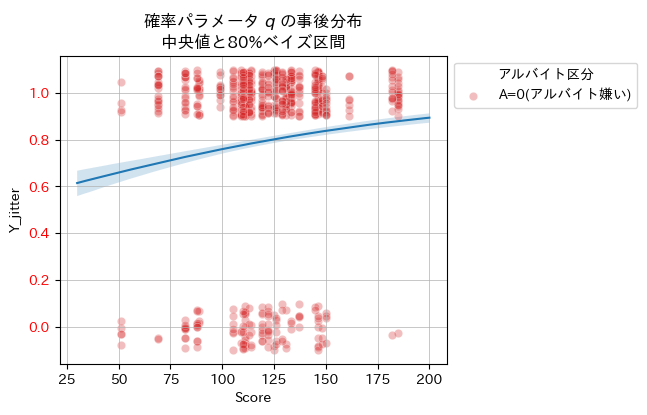

In [14]:
rng = np.random.default_rng(seed=1234)
# ロジスティック関数の定義
def logistic(x):
    return 1 / (1 + np.exp(-x))

# パラメータb: shape=(4, 4000)
b_samples = idata.posterior.b.stack(sample=("chain", "draw")).data

x_score_vals = np.arange(30, 201)
# x_score_vals = np.linspace(30, 201, 500)
# パラメータqの計算：b0 + b2*score/200
q_plot = np.array(
    [logistic(b_samples[0] + b_samples[2] * x_score_val / 200) for x_score_val in x_score_vals]
    )
print(q_plot.shape)
print(q_plot)
# CIを算出
q_plot_median = np.median(q_plot, axis=1)
q_plot_80ci = np.quantile(q_plot, q=[0.1, 0.9], axis=1)

# 実測値Y（アルバイト嫌いでA＝0、晴れなので：Weather=A）
y_plot = data.query("A==0 & Weather=='A'")[["Score", "Y"]]
# Yの描画の際に重なりを避けるためのjitterデータの作成
y_plot["Y_jitter"] = (y_plot["Y"] + rng.uniform(low=-0.1, high=0.1, size=y_plot.shape[0]))

plt.figure(figsize=(5, 4))
plt.plot(x_score_vals, q_plot_median)
plt.fill_between(x_score_vals, q_plot_80ci[0], q_plot_80ci[1],
                 alpha=0.2)
sns.scatterplot(x="Score", y="Y_jitter", data=y_plot,
                color="tab:red", alpha=0.3, label="A=0(アルバイト嫌い)")
plt.tick_params(axis='y', labelcolor='red')

plt.title("確率パラメータ $q$ の事後分布\n中央値と80%ベイズ区間")
plt.legend(bbox_to_anchor=(1,1), title="アルバイト区分")
plt.grid(lw=0.5)
plt.show()

## 確率パラメータ q の事後分布と目的変数 Y の観測値
出席確率の高さが実際の出席につながっているか？を確認したい。
- q vs Yの散布図
- 点が多い場合は、qの中央値の分布を表す密度関数または箱ひげ図を合わせて表示する

,Y,A,q
0,1,0,0.679826
1,1,0,0.699541
2,1,0,0.594019
3,1,0,0.699541
4,1,0,0.679826


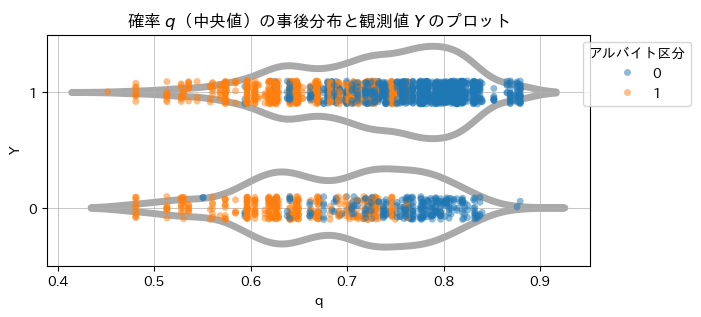

In [15]:
q_medians = idata.posterior.q.stack(stack=("chain", "draw")).median(axis=1).data

plot_data = pd.concat([data[["Y", "A"]], pd.DataFrame({"q": q_medians})], axis=1)
display(plot_data.head())
plot_data["Y"] = plot_data["Y"].astype("category")

plt.figure(figsize=(7,3))
sns.violinplot(x="q", y="Y", data=plot_data, 
               order=["1", "0"], 
               inner=None,
               fill=False, color="darkgray", linewidth=5)
sns.stripplot(x="q", y="Y", data=plot_data,
              hue="A", alpha=0.5)
plt.title("確率 $q$（中央値）の事後分布と観測値 $Y$ のプロット")
plt.legend(bbox_to_anchor=(1.2, 1), title="アルバイト区分")
plt.grid(lw=0.5)

↑ Y=0と1で分布の違いに大きな差がない、ように見える
- Y=1ではq→大、Y=0ではq→小、となっていると良さそうだが、そうなってる様子は微妙。。  
→十分に予測できているとは言えなさそう



In [16]:
q_samples = idata.posterior.q.stack(stack=("chain", "draw")).data

plot_data[["q10%", "q90%"]] = np.quantile(q_samples, q=[0.1, 0.9], axis=1).T 
print(np.quantile(q_samples, q=[0.1, 0.9], axis=1).T )
display(plot_data)

[[0.64666661 0.71076589]
 [0.66758667 0.72980803]
 [0.54623517 0.64089186]
 ...
 [0.60201626 0.64975248]
 [0.47374062 0.55262916]
 [0.47374062 0.55262916]]


,Y,A,q,q10%,q90%
0,1,0,0.679826,0.646667,0.710766
1,1,0,0.699541,0.667587,0.729808
2,1,0,0.594019,0.546235,0.640892
3,1,0,0.699541,0.667587,0.729808
4,1,0,0.679826,0.646667,0.710766
...,...,...,...,...,...
2391,1,1,0.604421,0.582144,0.627735
2392,1,1,0.626828,0.602016,0.649752
2393,1,1,0.626828,0.602016,0.649752
2394,1,1,0.513224,0.473741,0.552629


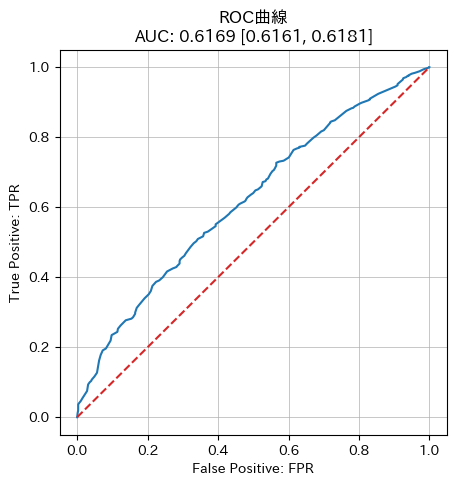

In [17]:
## ROC曲線描画用のデータ作成
# ROC曲線のx軸：fpr、y軸：tprの算出
fpr, tpr, threshold = roc_curve(plot_data['Y'], plot_data['q'])
fpr10, tpr10, threshold10 = roc_curve(plot_data['Y'], plot_data['q10%'])
fpr90, tpr90, threshold90 = roc_curve(plot_data['Y'], plot_data['q90%'])
# ROC-AUCスコアの算出
q_score = roc_auc_score(plot_data['Y'], plot_data['q'])
q10_score = roc_auc_score(plot_data['Y'], plot_data['q10%'])
q90_score = roc_auc_score(plot_data['Y'], plot_data['q90%'])

## 描画処理
# 描画領域の設定
plt.figure(figsize=(5, 5))
ax = plt.subplot()
# ROC曲線の青線の描画
ax.plot(fpr, tpr)
# 80%ベイズ信頼区間の描画（ただし、10%と90%のy軸が一致していない為、概算です）
# ax.fill_betweenx(tpr, fpr10, fpr90, alpha=0.3)
# 対角線の赤点線の描画
ax.plot([0, 1], [0, 1], color='tab:red', ls='--')
# 修飾
ax.set(xlabel='False Positive: FPR', ylabel='True Positive: TPR',
       title=f'ROC曲線\nAUC: '
             f'{q_score:.4f} [{q10_score:.4f}, {q90_score:.4f}]')
plt.grid(lw=0.5);

### 参考リンク
- ROCの解説：https://okumuralab.org/~okumura/stat/ROC.html
    - BER(Balanced Error Rate)：偽陽性率と偽陰性率の平均
    - BERが最小になる閾値がベスト
